In [3]:
import pickle as pkl

import lxml
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.datasets import imdb


from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding,\
                        GlobalMaxPooling1D,GlobalAveragePooling1D,GaussianNoise,BatchNormalization,Add
from tensorflow.keras.initializers import glorot_uniform
#from tensorflow.keras.utils.vis_utils import plot_model

import importlib
importlib.reload(tensorflow)

<module 'tensorflow' from '/miniconda/lib/python3.6/site-packages/tensorflow/__init__.py'>

## Helper Functions

In [121]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    NOTE: Taken from sklearn example
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0,1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    
    #ax.figsize((10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [40]:
from IPython.display import clear_output
class PlotLosses(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
        plt.plot(range(len(global_history)), global_history, label = 'Accuracy - Global')
        plt.plot(range(len(global_val_history)), global_val_history, label = 'Accuracy - Global - Va;')
        plt.legend()
        plt.show()
        
        plt.hist(predictions, label = 'Prediction Distribution')
        plt.legend()
        plt.show()    
        
        plt.hist(actual, label = 'Actual Distribution')
        plt.legend()
        plt.show()
        
plot_losses = PlotLosses()

In [36]:
tqdm.pandas()

In [37]:
import tensorflow as tf
with tf.Session() as sess:
    devices = sess.list_devices()

In [4]:
import sys

In [ ]:
!{sys.executable} -m list

## Reading the Data

In [6]:
iterator = True


if iterator == True:
    
    drugbank = pd.read_csv('data/intermediate/interactions_preprocessed.csv', chunksize = 7500, iterator = True, converters={"target_gene_encoded_padded": \
                                                                                         lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                        "drug_fingerprint_encoded_padded": \
                                                                                        lambda x: np.array(x.strip("[]").replace("'","").split(", "))})
if iterator == False:

    drugbank = pd.read_csv('data/intermediate/interactions_preprocessed.csv', converters={"target_gene_encoded_padded": \
                                                                                         lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                        "drug_fingerprint_encoded_padded": \
                                                                                        lambda x: np.array(x.strip("[]").replace("'","").split(", "))})

## CNN in Chunks

In [58]:

#drugbank = drugbank_reader.__next__()


In [37]:
drugbank

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y,target_gene_encoded,drug_fingerprint_encoded,target_gene_encoded_len,drug_fingerprint_encoded_len,mismatch,target_gene_encoded_mismatch,drug_fingerprint_encoded_mismatch,target_gene_encoded_padded,drug_fingerprint_encoded_padded
16500,DB01284,BE0003634,2246728737 3537119515 2245273601 3004333805 22...,ATGTTGTTCTCCGCCCTCCTGCTGGAGGTGATTTGGATCCTGGCTG...,0,[0 3 2 ... 3 0 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 3, 7, 1, ...",1014,4039,-3025,20208,5462,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
16501,DB05327,BE0008691,2968968094 1910766508 3217380708 3234104871 86...,ATGGGGGGCTCGGGCAGTCGCCTGTCCAAGGAGCTGCTGGCCGAGT...,0,[0 3 2 2 2 2 2 2 1 3 1 2 2 2 1 0 2 3 1 2 1 1 3...,"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 1, 9, 1, 0, 7, ...",576,498,78,20646,9003,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
16502,DB06932,BE0002622,2246728737 422715066 3217380708 3120642300 321...,ATGGAACAACAACCATTAACATTAACGGCGGCGACAACTCGTGCGC...,0,[0 3 2 ... 3 0 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 4, 2, 2, 7, 1, ...",2031,491,1540,19191,9010,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
16503,DB01766,BE0000048,3218693969 98513984 3218693969 98513984 321869...,ATGGCGCACGTCCGAGGCTTGCAGCTGCCTGGCTGCCTGGCCCTGG...,1,[0 3 2 ... 3 0 2],"[3, 2, 1, 8, 6, 9, 3, 9, 6, 9, 9, 8, 5, 1, 3, ...",1869,306,1563,19353,9195,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
16504,DB05327,BE0001814,2968968094 1910766508 3217380708 3234104871 86...,ATGCCATCACTCAGTAAAGAAGCGGCCCTGGTTCATGAAGCGTTAG...,0,[0 3 2 1 1 0 3 1 0 1 3 1 0 2 3 0 0 0 2 0 0 2 1...,"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 1, 9, 1, 0, 7, ...",669,498,171,20553,9003,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,DB02484,BE0003635,3218693969 951226070 3218693969 571978829 2092...,ATGGGGAGGCTGCTGGCCTTAGTGGTCGGCGCGGCACTGGTGTCCT...,0,[0 3 2 2 2 2 0 2 2 1 3 2 1 3 2 2 1 1 3 3 0 2 3...,"[3, 2, 1, 8, 6, 9, 3, 9, 6, 9, 9, 5, 1, 2, 2, ...",657,574,83,20565,8927,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
16996,DB02259,BE0001927,2246728737 3542456614 2245384272 618671879 321...,ATGGAAACCTATGCTGTTTTTGGTAATCCGATAGCCCACAGCAAAT...,0,[0 3 2 2 0 0 0 1 1 3 0 3 2 1 3 2 3 3 3 3 3 2 2...,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 2, 4, ...",819,696,123,20403,8805,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
16997,DB06855,BE0001739,2246728737 3537119515 2245273601 2423543607 22...,ATGAATCCACTCCTGATCCTTACCTTTGTGGCAGCTGCTCTTGCTG...,1,[0 3 2 0 0 3 1 1 0 1 3 1 1 3 2 0 3 1 1 3 3 0 1...,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 3, 7, 1, ...",744,487,257,20478,9014,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
16998,DB06201,BE0003790,3218693969 98513984 3218693969 951226070 32173...,ATGAGCAGAAGCAAGCGTGACAACAATTTTTATAGTGTAGAGATTG...,0,[0 3 2 ... 3 2 0],"[3, 2, 1, 8, 6, 9, 3, 9, 6, 9, 9, 8, 5, 1, 3, ...",1284,330,954,19938,9171,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


In [7]:
def identity_block(X, f, filters):
    
    # Number Of Filters For Each Block 
    F1, F2, F3 = filters
    
    # Save Input For Shortcut
    X_shortcut = X
    
    # Component 1
    X = Conv1D(filters = F1, kernel_size = 16, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Component 2 
    X = Conv1D(filters = F2, kernel_size = f, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Component 3 
    X = Conv1D(filters = F3, kernel_size = 16, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    
    # Add Shortcut Path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X
    

In [8]:
def convolutional_block(X, f, filters, s = 2):
    
    # Number Of Filters For Each Block 
    F1, F2, F3 = filters
    
    # Save Input For Shortcut
    X_shortcut = X
    
    ## Main Path 
    print ("X In Conv : " + str(X.shape))
    # Component 1 
    X = Conv1D(filters = F1, kernel_size = 16, strides = s, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    print ("Component 1 : " + str(X.shape))
    
    # Component 2
    X = Conv1D(filters = F2, kernel_size = f, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    print ("Component 2 : " + str(X.shape))
    
    # Component 3
    X = Conv1D(filters = F3, kernel_size = 16, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    print ("Component 3 : " + str(X.shape))
    
    ## Shortcut Path
    X_shortcut = Conv1D(filters = F3, kernel_size = 16, strides = s, padding = 'valid', kernel_initializer = glorot_uniform())(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    print ("X Shortcut : " + str(X_shortcut.shape))
    
    # Add Shortcut Path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [9]:
def ResNet_1D(input_shape = (30723, 1)):
    
    X_input = Input(input_shape)
    
    # Stage 1
    print ("X Input : " + str(X_input.shape))
    X = Conv1D(filters = 64, kernel_size = 16, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform())(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    print ("X : " + str(X.shape))
    
    # Stage 2 - 1 Conv Block & 2 Identity Blocks
    X = convolutional_block(X, f = 48, filters = [64, 64, 128], s = 1)
    X = identity_block(X, f = 48, filters = [64, 64, 128])
    X = identity_block(X, f = 48, filters = [64, 64, 128])
    
    # Stage 3 - 1 Conv Block & 3 Identity Blocks
    X = convolutional_block(X, f = 16, filters = [128, 128, 256])
    X = identity_block(X, f = 48, filters = [128, 128, 256])
    X = identity_block(X, f = 48, filters = [128, 128, 256])
    X = identity_block(X, f = 48, filters = [128, 128, 256])
    
    # Stage 4 - 1 Conv Block & 5 Identity Blocks
    X = convolutional_block(X, f = 32, filters = [256, 256, 512])
    X = identity_block(X, f = 48, filters = [256, 256, 512])
    X = identity_block(X, f = 48, filters = [256, 256, 512])
    X = identity_block(X, f = 48, filters = [256, 256, 512])
    X = identity_block(X, f = 48, filters = [256, 256, 512])
    X = identity_block(X, f = 48, filters = [256, 256, 512])
    
    # Stage 5 - 1 Conv Block & 2 Identity Blocks 
    X = convolutional_block(X, f = 48, filters = [512, 512, 1024])
    X = identity_block(X, f = 48, filters = [512, 512, 1024])
    X = identity_block(X, f = 48, filters = [512, 512, 1024])
    
    
    X = GlobalAveragePooling1D()(X)
    X = Flatten()(X)
    X = Dense(1, kernel_initializer = glorot_uniform())(X)
    X = Activation('sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X)
    
    return model
    

In [33]:
def VGG_16():

    #X_input = Input(input_shape)
    
    drugs_input = Input(shape=(9501,1))
    genes_input = Input(shape=(21222,1))
    
    # Convolution Block 1
    X_0 = Conv1D(filters = 64, kernel_size = 8, strides = 2, activation = 'relu')(genes_input)
    X_1 = Conv1D(filters = 64, kernel_size = 8, strides = 2, activation = 'relu')(drugs_input)
    
    X_0 = Conv1D(filters = 64, kernel_size = 8, strides = 2, activation = 'relu')(X_0)
    X_1 = Conv1D(filters = 64, kernel_size = 8, strides = 2, activation = 'relu')(X_1)

    X_0 = BatchNormalization()(X_0)
    X_1 = BatchNormalization()(X_1)
    
    #X = AveragePooling1D()(X_0)
    #X = AveragePooling1D()(X_1)
    
    
    # Convolution Block 2
    X_0 = Conv1D(filters = 128, kernel_size = 8, strides = 2, activation = 'relu')(X_0)
    X_1 = Conv1D(filters = 128, kernel_size = 8, strides = 2, activation = 'relu')(X_1)
    
    X_0 = Conv1D(filters = 128, kernel_size = 8, strides = 2, activation = 'relu')(X_0)
    X_1 = Conv1D(filters = 128, kernel_size = 8, strides = 2, activation = 'relu')(X_1)
    
    X_0 = BatchNormalization()(X_0)
    X_1 = BatchNormalization()(X_1)
    
    # Test Drop Out
    X_0 = Dropout(0.4)(X_0)
    X_1 = Dropout(0.4)(X_1)

    # Convolution Block 3
    X_0 = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu')(X_0)
    X_0 = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu')(X_0)
    X_0 = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu')(X_0)
    X_0 = BatchNormalization()(X_0)
    
    X_1 = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu')(X_1)
    X_1 = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu')(X_1)
    X_1 = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu')(X_1)
    X_1 = BatchNormalization()(X_1)
    
    # Test Drop Out
    X_0 = Dropout(0.5)(X_0)
    X_1 = Dropout(0.5)(X_1)

    # Convolution Block 4
    #X = Conv1D(filters = 512, kernel_size = 2, strides = 2, activation = 'relu')(X)
    #X = Conv1D(filters = 512, kernel_size = 2, strides = 2, activation = 'relu')(X)
    #X = Conv1D(filters = 512, kernel_size = 2, strides = 2, activation = 'relu')(X)
    #X = BatchNormalization()(X)
    # Test Drop Out
    # X = Dropout(0.7)(X)

    # Convolution Block 5
    #X = Conv1D(filters = 1024, kernel_size = 2, strides = 2, activation = 'relu')(X)
    #X = Conv1D(filters = 1024, kernel_size = 2, strides = 2, activation = 'relu')(X)
    #X = Conv1D(filters = 1024, kernel_size = 2, strides = 2, activation = 'relu')(X)
    #X = BatchNormalization()(X)
    
    X_0 = GlobalAveragePooling1D()(X_0)
    X_1 = GlobalAveragePooling1D()(X_1)

    combined = Concatenate(axis=-1)([X_0, X_1])

    X = Flatten()(combined)
    X = Dense(32, kernel_initializer = glorot_uniform())(X)
    X = Dense(1, kernel_initializer = glorot_uniform())(X)

    X = Activation('sigmoid')(X)

    model = Model(inputs = [drugs_input,genes_input] , outputs = X)

    return model

In [34]:
model = VGG_16()

In [80]:
# model = ResNet_1D()

In [35]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 21222, 1)     0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 9501, 1)      0                                            
__________________________________________________________________________________________________
conv1d_43 (Conv1D)              (None, 10608, 64)    576         input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_44 (Conv1D)              (None, 4747, 64)     576         input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_45 

In [37]:
model_optimizer = tensorflow.keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, amsgrad=False)
hidden_dims_3 = 32
batch_size = 10
epochs = 5
trim_width = 0

class_weight = {0: 1.,
                1: 5}

model.compile(loss = 'binary_crossentropy', optimizer = model_optimizer, metrics = ['binary_accuracy'])



In [83]:
#Uncomment to read model
#model = tensorflow.keras.models.load_model('models/CNN_GPU_VGG_85p.model')

In [ ]:
%%time

#drugbank = pd.read_csv('../data/intermediate/interactions_preprocessed.csv', chunksize = 500, iterator = True, converters={"target_gene_encoded_padded": \
#                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
#                                                                                    "drug_fingerprint_encoded_padded": \
#                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})


drugbank = pd.read_csv('data/intermediate/interactions_preprocessed.csv', iterator = False, converters={"target_gene_encoded_padded": \
                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                    "drug_fingerprint_encoded_padded": \
                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})
drugbank = drugbank.sort_values('drug_id')
drugbank_reader = np.array_split(drugbank, len(drugbank)/500)


In [8]:
#drugbank_test = drugbank_reader.__next__()
drugbank_test = drugbank_reader[0]

In [9]:
## Use if DRUGBANK DF is already in memory


In [22]:
drugbank_test['drug_fingerprint_encoded_padded']

0      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
1      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
2      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
3      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
4      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
                             ...                        
495    [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
496    [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
497    [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
498    [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
499    [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
Name: drug_fingerprint_encoded_padded, Length: 500, dtype: object

In [16]:
len(drugbank_test['target_gene_encoded_padded'][0])

21222

In [23]:
len(drugbank_test['drug_fingerprint_encoded_padded'][0])

9501

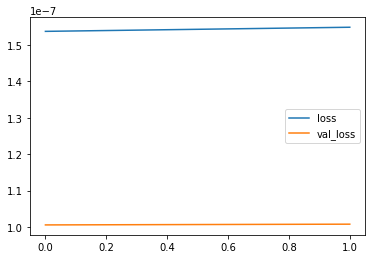

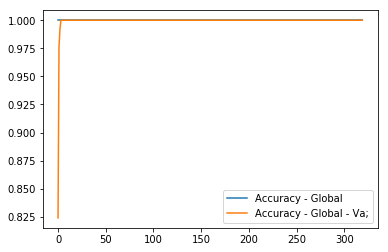

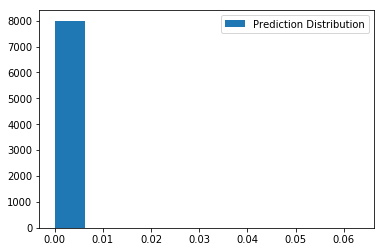

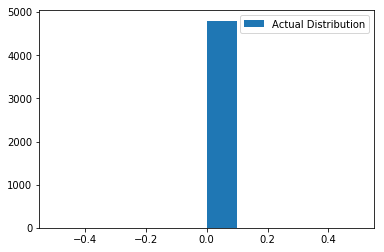

 - 2s - loss: 1.5484e-07 - binary_accuracy: 1.0000 - val_loss: 1.0077e-07 - val_binary_accuracy: 1.0000
Epoch 3/5


In [ ]:
global_history = []
global_val_history = []
predictions = []
actual = []

with open('../data/gene_encoder.pkl', 'rb') as f:
    label_encoder = pkl.load(f)
    

for drugbank in tqdm(drugbank_reader):
    
    
    print('Reading chunk from file..')
    #drugbank = drugbank_reader.__next__()
    
    #drugbank['target_gene_encoded'] = drugbank['target_gene_code'].progress_apply(\
    #                                   lambda x: label_encoder.transform([i for i in list(x) if i in gene_chars]))
    #drugbank['drug_fingerprint_encoded'] = drugbank['drug_fingerprint_code'].progress_apply(lambda x: [int(i) for i in x.replace(' ', '')])

    
    print('Sampling..')
    train_df_inter, test_df = train_test_split(drugbank)

    ##FORCE TRAIN NEGATIVE SAMPLES ON LOW EPOCH
    train_df = pd.DataFrame()
    
    if len(train_df_inter[train_df_inter['Y'] == 0]) > 2:
        train_df = train_df.append(train_df_inter[train_df_inter['Y'] == 0].sample(frac = 0.2))
    
    if len(train_df_inter[train_df_inter['Y'] == 1]) > 2:
        train_df = train_df.append(train_df_inter[train_df_inter['Y'] == 1].sample(frac = 1.0))

    
    print('Padding..') 
    X_0 = np.array(list(train_df['target_gene_encoded_padded']))
    X_1 = np.array(list(train_df['drug_fingerprint_encoded_padded']))
    Y   = np.array(list(train_df['Y']))
    

    X_0_test = np.array(list(test_df['target_gene_encoded_padded']))
    X_1_test = np.array(list(test_df['drug_fingerprint_encoded_padded']))
        
    Y_test   = np.array(list(test_df['Y']))
    
    print(X_0.shape)
    print(X_1.shape)
    
    print(X_0_test.shape)
    print(X_1_test.shape)

    print('Trimming..')
    X_0 = X_0[:, int(trim_width/2) : X_0.shape[1] - int(trim_width/2)]
    X_1 = X_1[:, int(trim_width/2) : X_1.shape[1] - int(trim_width/2)]
    
    X_0_test = X_0_test[:, int(trim_width/2) : X_0_test.shape[1] - int(trim_width/2)]
    X_1_test = X_1_test[:, int(trim_width/2) : X_1_test.shape[1] - int(trim_width/2)]
    

    X_0 = X_0.astype(int) + 1
    X_1 = X_1.astype(int) + 1
    Y   = Y.astype(int)

    X_0_test = X_0_test.astype(int) + 1
    X_1_test = X_1_test.astype(int) + 1
    Y_test   = Y_test.astype(int)
    
    print(X_0.shape)
    print(X_1.shape)
    
    print(X_0_test.shape)
    print(X_1_test.shape)


    #X_0 = np.hstack((X_0, X_1))
    #X_0_test = np.hstack((X_0_test, X_1_test))

    print('Modelling..')
    
    print("X0 Shape : " + str(X_0.shape))
    print("X1 Shape : " + str(X_1.shape))
    
    print("X0 Test Shape : " + str(X_0_test.shape))
    print("X1 Test Shape : " + str(X_1_test.shape))
    
    
    history = model.fit([X_1[..., np.newaxis],X_0[..., np.newaxis]], Y,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=[plot_losses],
                          validation_data=([X_1_test[..., np.newaxis],X_0_test[..., np.newaxis]], Y_test), verbose = 2)


    actual.extend(Y.tolist())
    predictions.extend(model.predict([X_1_test[..., np.newaxis],X_0_test[..., np.newaxis]]).ravel())
    
    global_val_history.extend(history.history['val_binary_accuracy'])
    global_history.extend(history.history['binary_accuracy'])


    

In [127]:
predictions

[0.98074645,
 0.88115263,
 0.99116,
 0.997341,
 0.9973665,
 0.485927,
 0.24586682,
 0.35875657,
 0.97028,
 0.023148246,
 0.91211563,
 0.9530089,
 0.983422,
 0.5242317,
 0.99864906,
 0.13026431,
 0.96479434,
 0.060366888,
 0.9585344,
 0.97205544,
 0.99859005,
 0.01454602,
 0.122733355,
 0.18603781,
 0.31022176,
 0.9940156,
 0.99561524,
 0.016234249,
 0.99978083,
 0.0010744178,
 0.0075882426,
 0.99766374,
 0.9676747,
 0.99949,
 0.9647151,
 0.9092194,
 0.99734664,
 0.98956126,
 0.7344975,
 0.9986046,
 0.0056050196,
 0.9171512,
 0.88113123,
 0.683039,
 0.11081901,
 0.005810669,
 0.028459676,
 0.5640745,
 0.99363434,
 0.95544225,
 0.47065657,
 0.036709305,
 0.30858535,
 0.9996543,
 0.49400303,
 0.8550206,
 0.97474796,
 0.96738315,
 0.9981025,
 0.9982058,
 0.55262256,
 0.9989317,
 0.99225134,
 0.07087184,
 0.9994338,
 0.5092149,
 0.99687284,
 0.99960214,
 0.025848545,
 0.36379582,
 0.999907,
 0.97094035,
 0.0273537,
 0.6304575,
 0.033402417,
 0.14404131,
 0.9724326,
 0.27622315,
 0.99869066,

In [137]:
model.save('models/CNN_GPU_VGG_rebalance.model')

In [128]:
print('Padding..') 
X_0 = np.array(list(drugbank_test['target_gene_encoded_padded']))
X_1 = np.array(list(drugbank_test['drug_fingerprint_encoded_padded']))
Y   = np.array(list(drugbank_test['Y']))


X_0_test = np.array(list(drugbank_test['target_gene_encoded_padded']))
X_1_test = np.array(list(drugbank_test['drug_fingerprint_encoded_padded']))

Y_test   = np.array(list(drugbank_test['Y']))

print(X_0.shape)
print(X_1.shape)

print(X_0_test.shape)
print(X_1_test.shape)

print('Trimming..')
X_0 = X_0[:, int(trim_width/2) : X_0.shape[1] - int(trim_width/2)]
X_1 = X_1[:, int(trim_width/2) : X_1.shape[1] - int(trim_width/2)]

X_0_test = X_0_test[:, int(trim_width/2) : X_0_test.shape[1] - int(trim_width/2)]
X_1_test = X_1_test[:, int(trim_width/2) : X_1_test.shape[1] - int(trim_width/2)]


X_0 = X_0.astype(int) + 1
X_1 = X_1.astype(int) + 1
Y   = Y.astype(int)

X_0_test = X_0_test.astype(int) + 1
X_1_test = X_1_test.astype(int) + 1
Y_test   = Y_test.astype(int)

print(X_0.shape)
print(X_1.shape)

print(X_0_test.shape)
print(X_1_test.shape)


X_0 = np.hstack((X_0, X_1))
X_0_test = np.hstack((X_0_test, X_1_test))



Y_test = model.predict(X_0[..., np.newaxis])

Padding..
(500, 21222)
(500, 9501)
(500, 21222)
(500, 9501)
Trimming..
(500, 21222)
(500, 9501)
(500, 21222)
(500, 9501)


(array([169.,  38.,  31.,  27.,  19.,  22.,  25.,  26.,  42., 101.]),
 array([1.62358174e-05, 1.00014612e-01, 2.00012989e-01, 3.00011365e-01,
        4.00009741e-01, 5.00008118e-01, 6.00006494e-01, 7.00004871e-01,
        8.00003247e-01, 9.00001624e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

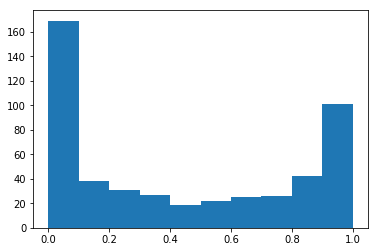

In [129]:
plt.hist(Y_test)

In [130]:
Y_test = [1 if (i > 0.5) else 0 for i in Y_test ]
cm = confusion_matrix(Y_test, Y)

In [131]:
cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

array([[0.78873239, 0.21126761],
       [0.4212963 , 0.5787037 ]])

In [132]:
f1_score(Y_test, Y)

0.6234413965087282

Confusion matrix, without normalization
[[224  91]
 [ 60 125]]
Normalized confusion matrix
[[0.71111111 0.28888889]
 [0.32432432 0.67567568]]


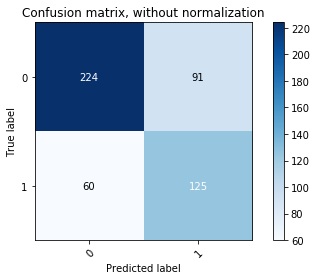

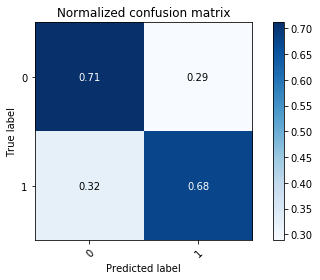

In [133]:
plot_confusion_matrix(Y, Y_test, classes=[0, 1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y, Y_test, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')

In [138]:
print(classification_report(Y, Y_test))

             precision    recall  f1-score   support

          0       0.79      0.71      0.75       315
          1       0.58      0.68      0.62       185

avg / total       0.71      0.70      0.70       500



In [139]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 30723, 1)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 5121, 64)          192       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 854, 64)           8256      
_________________________________________________________________
batch_normalization_3 (Batch (None, 854, 64)           256       
_________________________________________________________________
average_pooling1d_1 (Average (None, 427, 64)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 213, 128)          16512     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 106, 128)          32896     
__________